In [1]:
!hostname

n96.clstr


This Jupyter notebook is used to explore the relationship between temperatures and ROS 
- 
- Compares 2 meter Temps to ROS hours 
- Compares ROS Temperatures to Seasonal Temperatures (Nov thorugh March)
- Explores Distributions of data 
- Look into other temperatures such as 850,925, and 950

In [1]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import re
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from scipy.stats import linregress

Loading in the data 

In [2]:
path='/center1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ROS_Tlevels/'
pattern=f'ROS_Tl*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')


start_year = '1950-1951'
data = data.sel(season=data.season >= start_year)
seasons=data['season']

Loading in the shapefiles for boundary and Fairbanks 

In [51]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)
lat=data['XLAT']
lon=data['XLONG']

In [94]:
ros_hourly_totals_climatology = []
for i in range(len(data['ros_tally'].season)):
    val = data['ros_tally'].isel(season=i).sum().compute().item()
    ros_hourly_totals_climatology.append(val)

In [95]:
n_pixels_per_season = []

for i in range(len(data['ros_tally'].season)):
    ros_this_season = data['ros_tally'].isel(season=i)

    grid_with_ros = ros_this_season > 0
    # Count how many grid cells had ROS
    n_pixels = grid_with_ros.sum().compute().item()
    n_pixels_per_season.append(n_pixels)

ros_hours_normalized = [total / n if n > 0 else np.nan 
                        for total, n in zip(ros_hourly_totals_climatology, n_pixels_per_season)]

In [11]:
#Finding the average temperature for each winter season 
T2_avg_fnsb=[]
for i in range(len(data['T2_avg'].season)):
    avg=data['T2_avg'].isel(season=i).mean().compute().item()
    #avg = (avg - 273.15) * 9/5 + 32
    T2_avg_fnsb.append(avg)
print(T2_avg_fnsb)

[253.6638946533203, 256.2445068359375, 258.71893310546875, 256.2822265625, 257.35760498046875, 252.78968811035156, 256.491943359375, 259.8514709472656, 255.8328399658203, 258.52606201171875, 258.4056091308594, 255.4522705078125, 259.1460876464844, 256.60601806640625, 255.94979858398438, 255.0322723388672, 255.7603302001953, 258.278076171875, 255.39747619628906, 260.37982177734375, 253.1292266845703, 253.0487518310547, 256.72576904296875, 254.90675354003906, 255.6294708251953, 255.15756225585938, 262.10626220703125, 258.4698791503906, 257.752197265625, 259.2404479980469, 261.215576171875, 256.3980712890625, 257.54888916015625, 258.83929443359375, 258.83319091796875, 259.5689392089844, 260.4145812988281, 260.30523681640625, 256.3272705078125, 255.6563262939453, 256.0351257324219, 257.611328125, 259.241943359375, 258.833984375, 256.27154541015625, 257.2996520996094, 256.60821533203125, 259.86328125, 255.9529266357422, 258.1968994140625, 262.60406494140625, 259.00823974609375, 262.36676025

In [14]:
#finding the average temperature for each winter season ONLY when ROS hours occured
T2_avg_ROS_fnsb=[]
for i in range(len(data['T2_ros_avg'].season)):
    avg=data['T2_ros_avg'].isel(season=i).mean().compute().item()
    #avg = (avg - 273.15) * 9/5 + 32
    T2_avg_ROS_fnsb.append(avg)
print(T2_avg_ROS_fnsb)

[273.5365905761719, 274.4069519042969, 275.2947998046875, 274.2391052246094, 275.7564392089844, 274.0252990722656, 273.7991638183594, 274.3817443847656, 272.8463134765625, 273.9611511230469, 274.5200500488281, 274.2707214355469, 274.2789306640625, 274.4934387207031, 274.83282470703125, 273.64251708984375, 274.27923583984375, 274.5972595214844, 274.312255859375, 275.0191650390625, 274.4517517089844, 271.8697204589844, 274.29925537109375, 274.32635498046875, 274.37786865234375, 274.3719787597656, 275.53314208984375, 273.2033386230469, 274.0252990722656, 275.3018493652344, 274.655517578125, 275.10595703125, 274.1907653808594, 274.24212646484375, 274.1531982421875, 274.68756103515625, 274.4260559082031, 274.2876892089844, 274.4851379394531, 274.34912109375, 274.2115478515625, 274.0396728515625, 274.3934631347656, 274.336669921875, 274.1537170410156, 275.9090576171875, 273.5691833496094, 274.37860107421875, 272.4967956542969, 272.91778564453125, 274.53802490234375, 273.6997375488281, 274.85

In [56]:
print('Average Temp Nov-Mar', np.mean(T2_avg_fnsb))
print('When ROS occurs average temp', np.mean(T2_avg_ROS_fnsb))

Average Temp Nov-Mar 257.85992266680745
When ROS occurs average temp 274.28003465807114


In [15]:
T2_avg_ROS_fnsb_C=np.array(T2_avg_ROS_fnsb)-273.15
T2_avg_fnsb_C=np.array(T2_avg_fnsb)-273.15

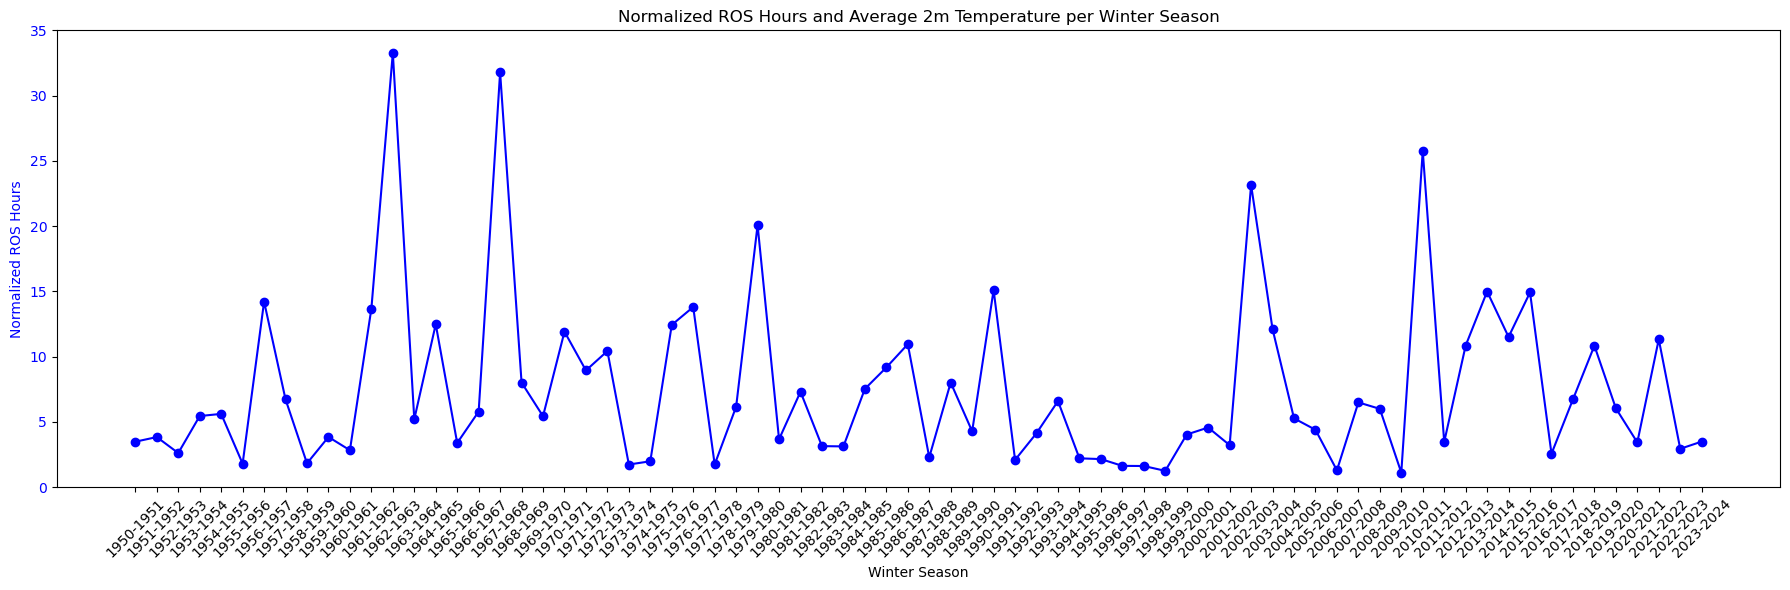

In [58]:
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='center')
plt.title('Normalized ROS Hours and Average 2m Temperature per Winter Season')
fig.tight_layout()
plt.show()

In [106]:
'''df = pd.DataFrame({
    'Winter Season': seasons,
    'Normalized ROS Hours': ros_hours_normalized
})

df.to_csv('/center1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ros_hours_per_season.csv', index=False)
'''

"df = pd.DataFrame({\n    'Winter Season': seasons,\n    'Normalized ROS Hours': ros_hours_normalized\n})\n\ndf.to_csv('/center1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ros_hours_per_season.csv', index=False)\n"

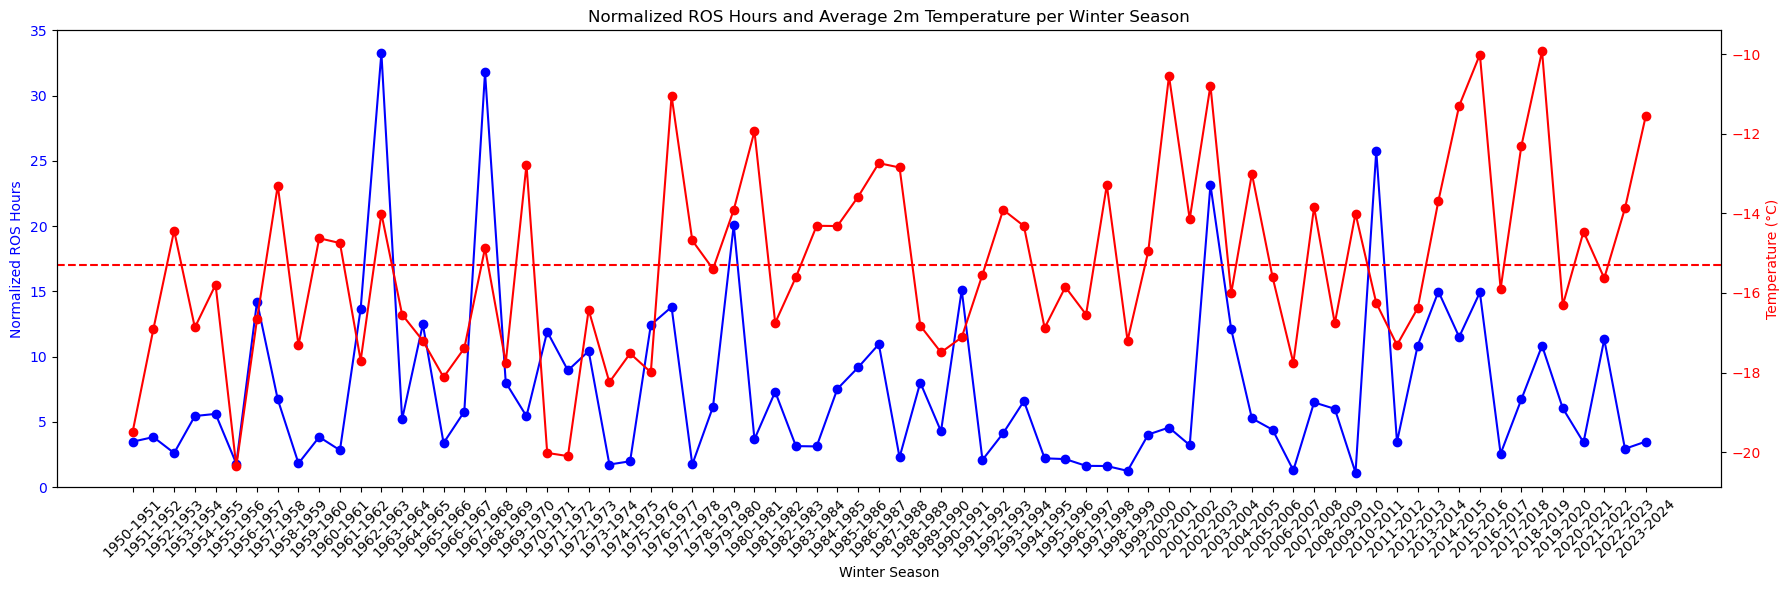

In [60]:
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, T2_avg_fnsb_C, marker='o', linestyle='-', color='red', label='Avg T2 (°C)')
plt.axhline(np.mean(T2_avg_fnsb_C), color='red', linestyle='--') 
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='center')
plt.title('Normalized ROS Hours and Average 2m Temperature per Winter Season')
fig.tight_layout()
plt.show()

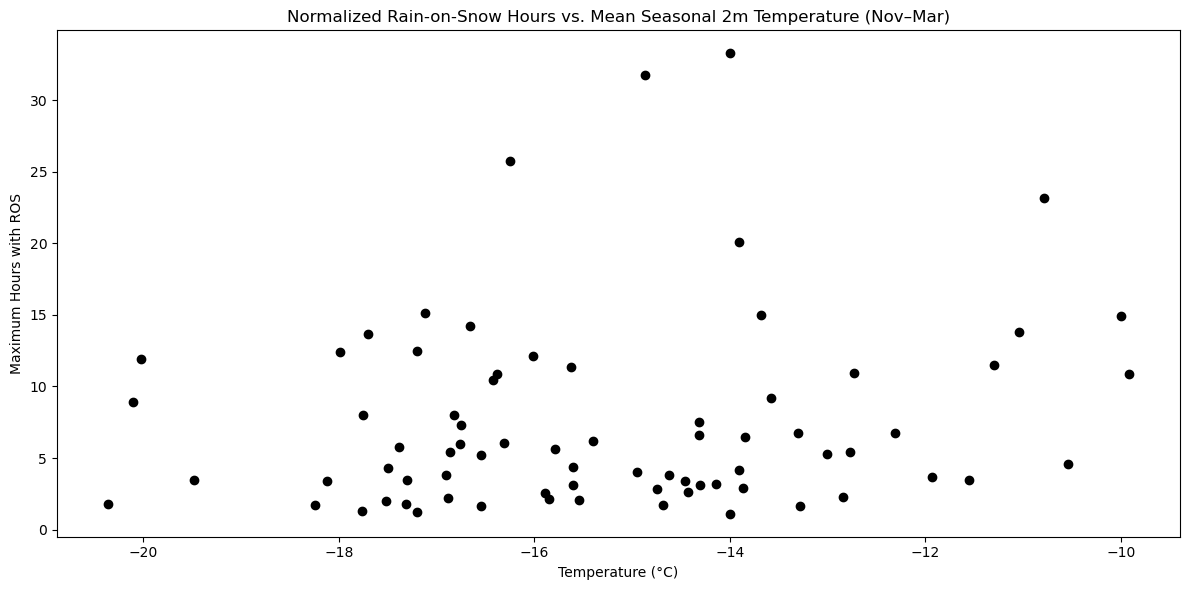

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(T2_avg_fnsb_C, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. Mean Seasonal 2m Temperature (Nov–Mar)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Maximum Hours with ROS')
plt.tight_layout()
plt.show()

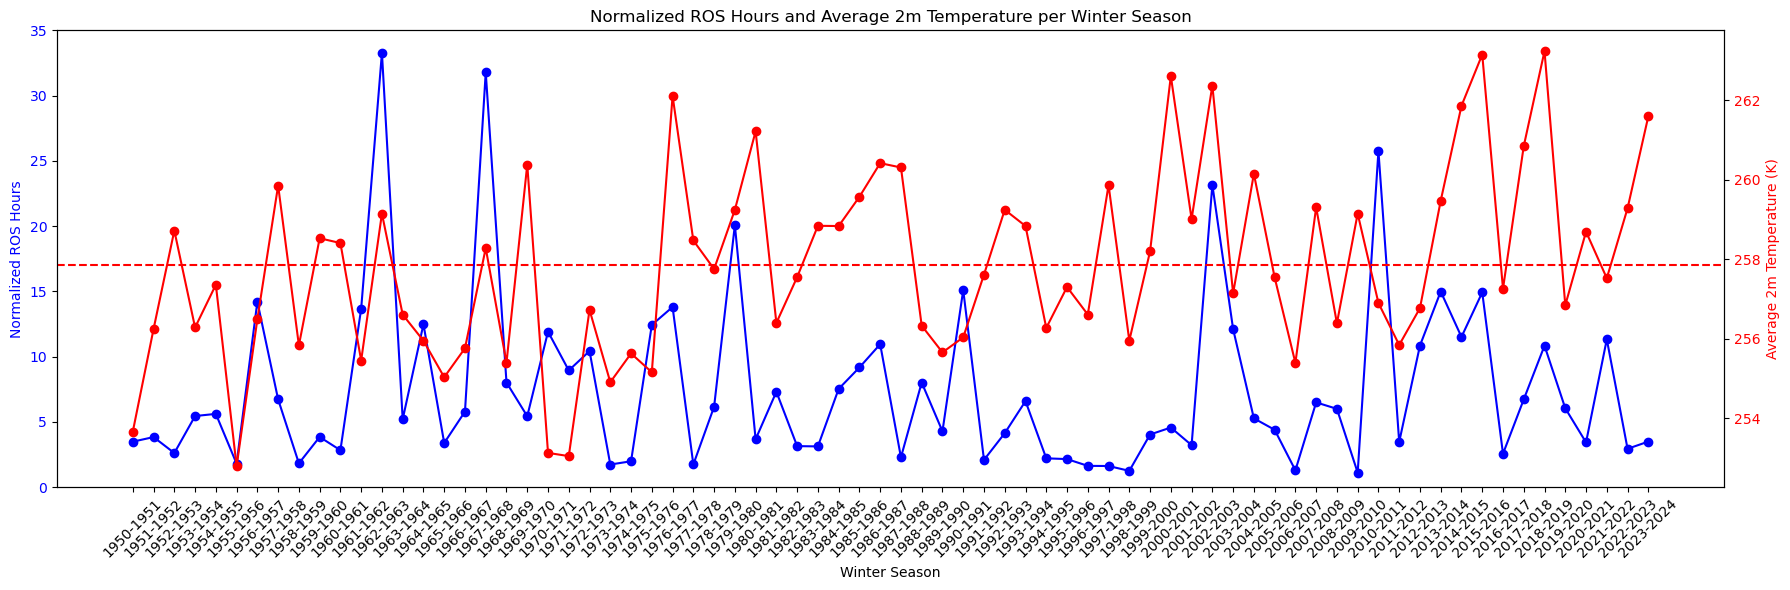

In [62]:
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, T2_avg_fnsb, marker='o', linestyle='-', color='red', label='Avg T2 (K)')
plt.axhline(np.mean(T2_avg_fnsb), color='red', linestyle='--') 
ax2.set_ylabel('Average 2m Temperature (K)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='center')
plt.title('Normalized ROS Hours and Average 2m Temperature per Winter Season')
fig.tight_layout()
plt.show()

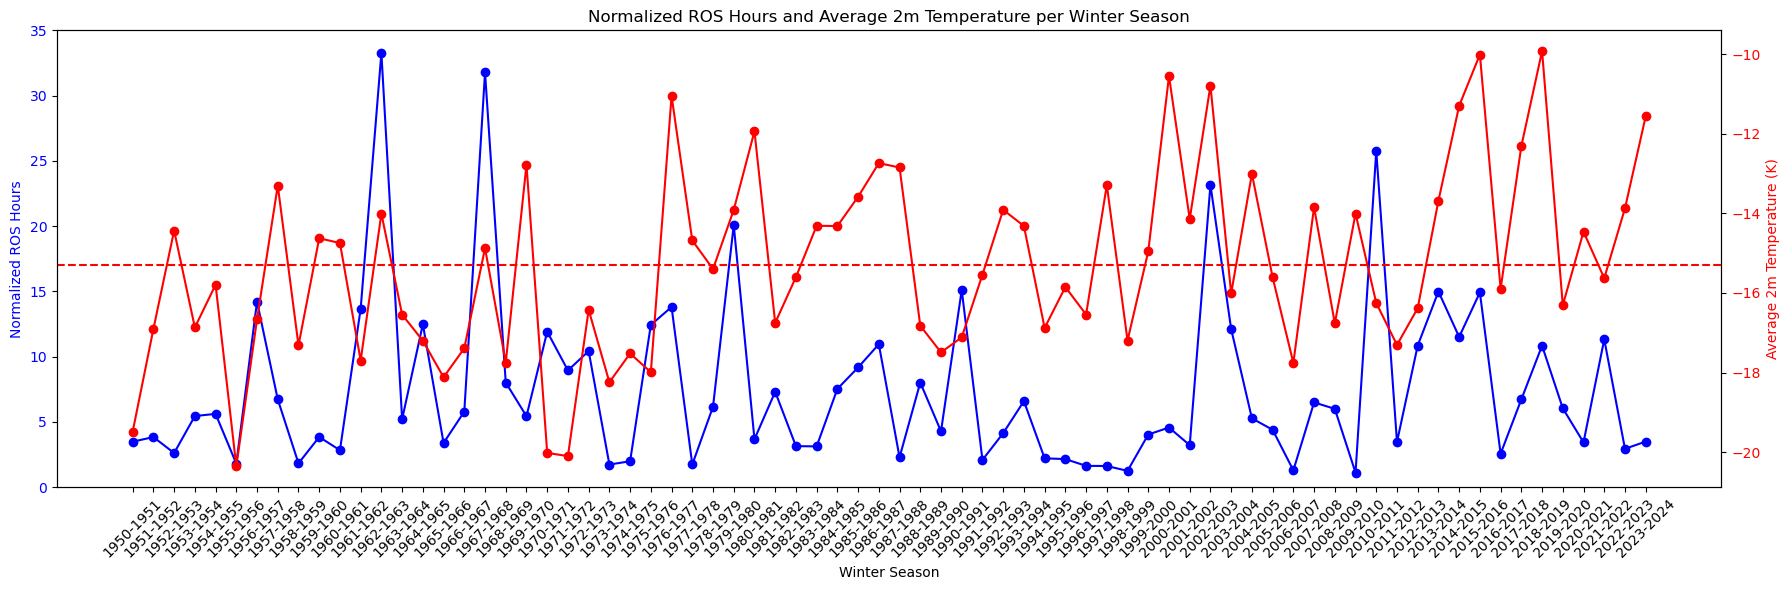

In [63]:
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, T2_avg_fnsb_C, marker='o', linestyle='-', color='red', label='Avg T2 (K)')
plt.axhline(np.mean(T2_avg_fnsb_C), color='red', linestyle='--') 
ax2.set_ylabel('Average 2m Temperature (K)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='center')
plt.title('Normalized ROS Hours and Average 2m Temperature per Winter Season')
fig.tight_layout()
plt.show()

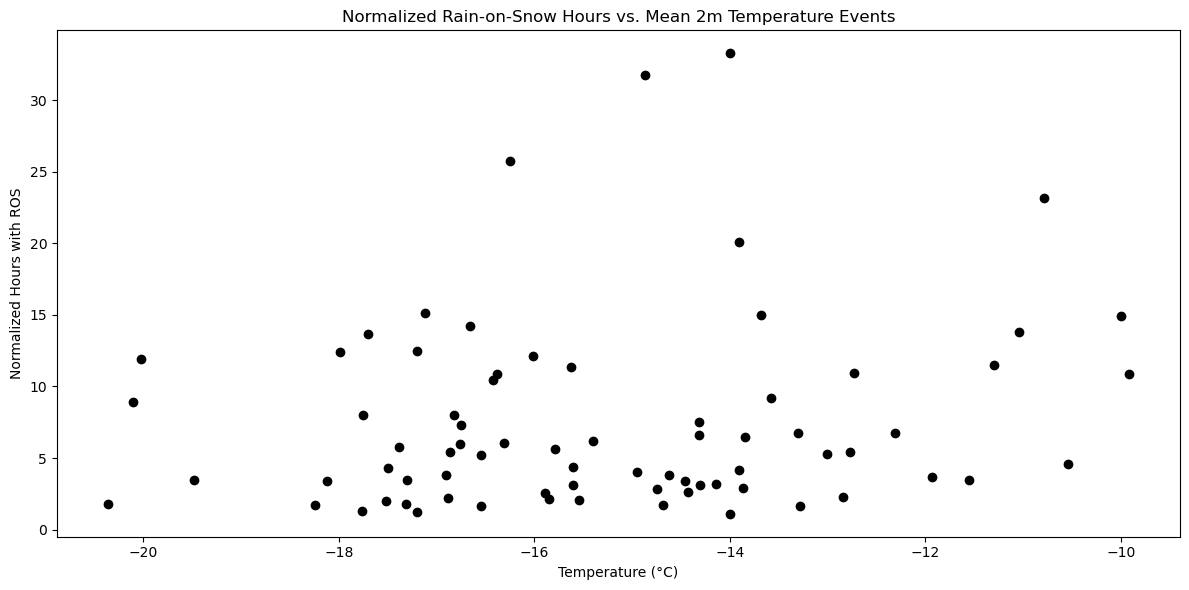

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(T2_avg_fnsb_C, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. Mean 2m Temperature Nov-Mar')
plt.xlabel('Temperature (°C)')
plt.ylabel('Normalized Hours with ROS')

plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.show()

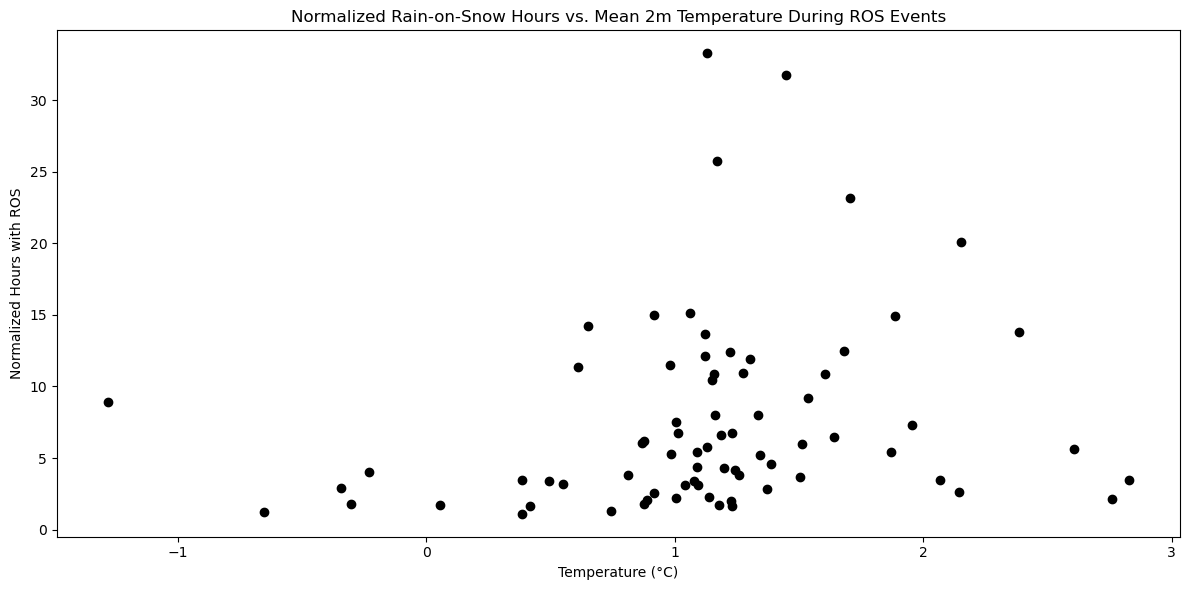

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(T2_avg_ROS_fnsb_C, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. Mean 2m Temperature During ROS Events')
plt.xlabel('Temperature (°C)')
plt.ylabel('Normalized Hours with ROS')
plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.show()

In [66]:
daily_max_values = []
for season in seasons:
    season_data = data.where(data['season'] == season, drop=True)
    
    if season_data['ros_days_count'].size == 0:
        daily_max_values.append(None)  
        continue
    max_val = season_data['ros_days_count'].max().compute().item()
    daily_max_values.append(max_val)

In [67]:
max(ros_hourly_totals_climatology)

38463

Exploring the dsitributions 

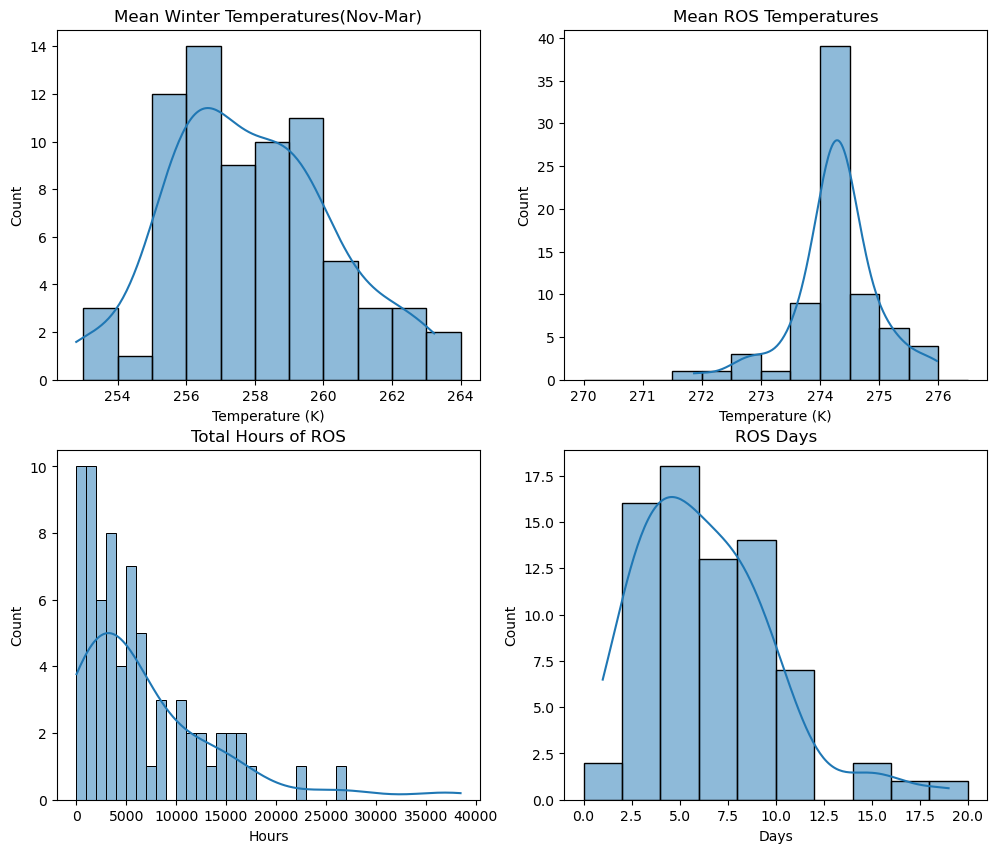

In [68]:
fig,axs=plt.subplots(2,2,figsize=(12, 10))

T_Bins=np.arange(253, 265, 1) 
sns.histplot(T2_avg_fnsb, kde=True, ax=axs[0,0],bins=T_Bins)
axs[0, 0].set_title("Mean Winter Temperatures(Nov-Mar)")
axs[0, 0].set(xlabel='Temperature (K)')

ROST_Bins=np.arange(270, 277, 0.5) 
sns.histplot(T2_avg_ROS_fnsb, kde=True, ax=axs[0,1], bins=ROST_Bins)
axs[0, 1].set_title("Mean ROS Temperatures")
axs[0, 1].set(xlabel='Temperature (K)')

hours_bins=np.arange(0, 28000, 1000)
sns.histplot(ros_hourly_totals_climatology, kde=True,ax=axs[1,0],bins=hours_bins)
axs[1, 0].set_title("Total Hours of ROS")
axs[1, 0].set(xlabel='Hours')

days_bins=np.arange(0,22,2)
sns.histplot(daily_max_values, kde=True,ax=axs[1,1],bins=days_bins)
axs[1,1].set_title("ROS Days")
axs[1, 1].set(xlabel='Days')
fig.patch.set_alpha(0.0)

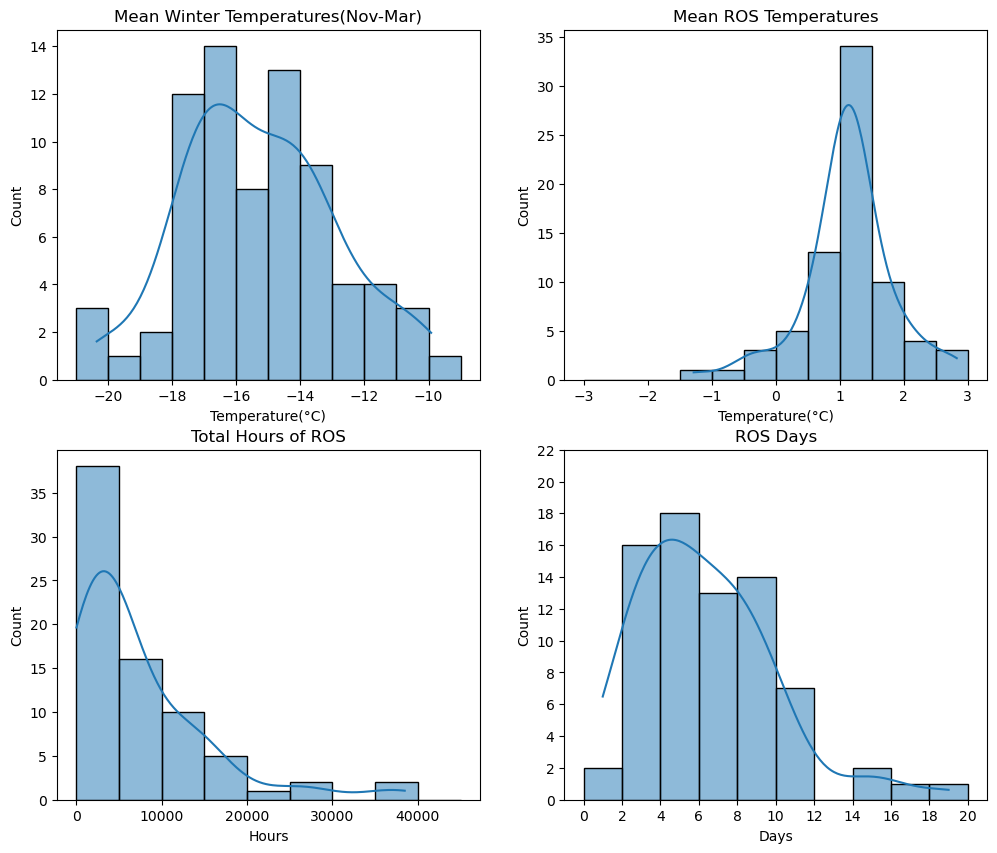

In [69]:
fig,axs=plt.subplots(2,2,figsize=(12, 10))

T_Bins=np.arange(-21, -8, 1) 
sns.histplot(T2_avg_fnsb_C, kde=True, ax=axs[0,0],bins=T_Bins)
axs[0, 0].set_title("Mean Winter Temperatures(Nov-Mar)")
axs[0, 0].set(xlabel='Temperature(°C)')

ROST_Bins=np.arange(-3, 3.5, 0.5) 
sns.histplot(T2_avg_ROS_fnsb_C, kde=True, ax=axs[0,1], bins=ROST_Bins)
axs[0, 1].set_title("Mean ROS Temperatures")
axs[0, 1].set(xlabel='Temperature(°C)')

hours_bins=np.arange(0, 50000, 5000)
sns.histplot(ros_hourly_totals_climatology, kde=True,ax=axs[1,0],bins=hours_bins)
axs[1, 0].set_title("Total Hours of ROS")
axs[1, 1].set_xticks(np.arange(0, 28000, 1000))
axs[1, 0].set(xlabel='Hours')

days_bins=np.arange(0,22,2)
sns.histplot(daily_max_values, kde=True,ax=axs[1,1],bins=days_bins)
axs[1,1].set_title("ROS Days")
axs[1, 1].set(xlabel='Days')
axs[1, 1].set_xticks(np.arange(0, 22,2))
axs[1, 1].set_yticks(np.arange(0, 24,2))
fig.patch.set_alpha(0.0)



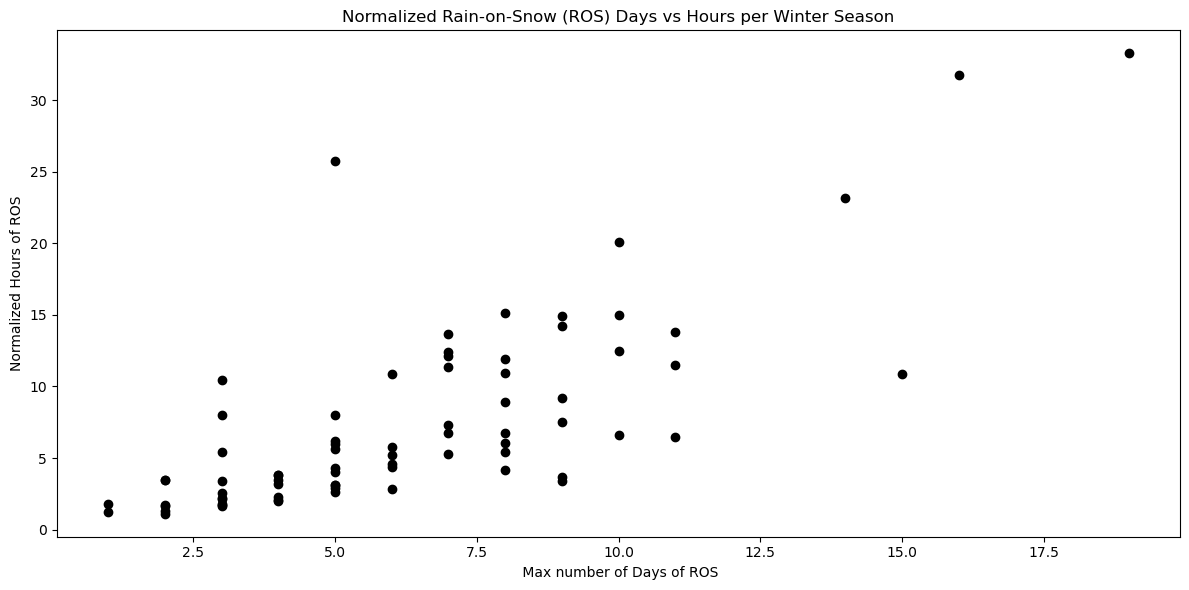

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(daily_max_values, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow (ROS) Days vs Hours per Winter Season')
plt.xlabel(' Max number of Days of ROS')
plt.ylabel('Normalized Hours of ROS')
plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.show()

In [71]:
correlation_matrix = np.corrcoef(daily_max_values, ros_hourly_totals_climatology)
correlation = correlation_matrix[0, 1]
print(f"Daily max values versus Hours: Pearson correlation: {correlation:.3f}")

correlation_matrix = np.corrcoef(ros_hourly_totals_climatology, T2_avg_fnsb)
correlation = correlation_matrix[0, 1]
print(f"Hours of ROS to Mean Temperatures from Nov-March Per Season: Pearson correlation: {correlation:.3f}")

correlation_matrix = np.corrcoef(ros_hourly_totals_climatology, T2_avg_ROS_fnsb)
correlation = correlation_matrix[0, 1]
print(f"Hours of ROS to Mean Temperatures during ROS hours: Pearson correlation: {correlation:.3f}")

Daily max values versus Hours: Pearson correlation: 0.784
Hours of ROS to Mean Temperatures from Nov-March Per Season: Pearson correlation: 0.223
Hours of ROS to Mean Temperatures during ROS hours: Pearson correlation: 0.238


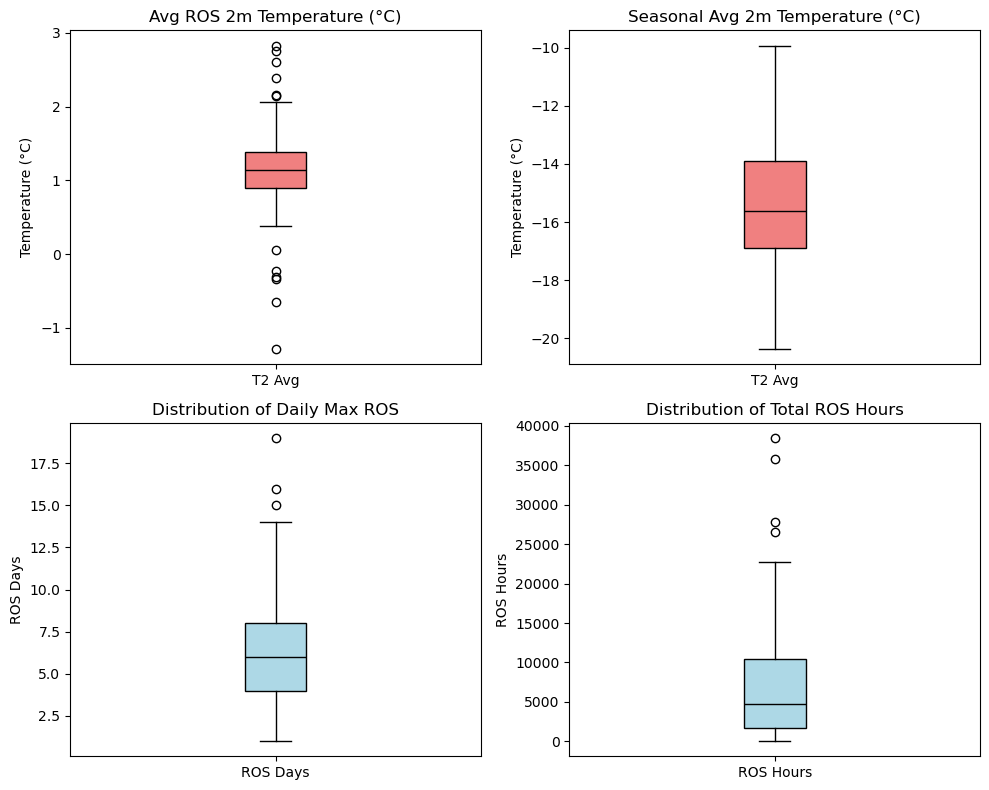

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].boxplot(T2_avg_ROS_fnsb_C, patch_artist=True,boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='black'))
axs[0, 0].set_title('Avg ROS 2m Temperature (°C)')
axs[0, 0].set_ylabel('Temperature (°C)')
axs[0, 0].set_xticks([1])
axs[0, 0].set_xticklabels(['T2 Avg'])

axs[0, 1].boxplot(T2_avg_fnsb_C, patch_artist=True, boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='black'))
axs[0, 1].set_title('Seasonal Avg 2m Temperature (°C)')
axs[0, 1].set_ylabel('Temperature (°C)')
axs[0, 1].set_xticks([1])
axs[0, 1].set_xticklabels(['T2 Avg'])

axs[1, 0].boxplot(daily_max_values, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='black'))
axs[1, 0].set_title('Distribution of Daily Max ROS')
axs[1, 0].set_ylabel('ROS Days')
axs[1, 0].set_xticks([1])
axs[1, 0].set_xticklabels(['ROS Days'])

axs[1, 1].boxplot(ros_hourly_totals_climatology, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='black'))
axs[1, 1].set_title('Distribution of Total ROS Hours')
axs[1, 1].set_ylabel('ROS Hours')
axs[1, 1].set_xticks([1])
axs[1, 1].set_xticklabels(['ROS Hours'])

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

Now looking into 850 hPa Mean Temperatures (Calculated over both the entire season (Nov-Mar) and also only when ROS occurs)
- 


In [74]:
avg_temp_850=np.mean(data['temp_levels_avg'].sel(interp_level=850),axis=0)
avg_temp_925=np.mean(data['temp_levels_avg'].sel(interp_level=925),axis=0)
avg_temp_950=np.mean(data['temp_levels_avg'].sel(interp_level=950),axis=0)
avg_temp_850_C=avg_temp_850-273.15
avg_temp_925_C=avg_temp_925-273.15
avg_temp_950_C=avg_temp_950-273.15

In [75]:
avg_ros_temp_850=np.mean(data['temp_levels_ros_avg'].sel(interp_level=850),axis=0)
avg_ros_temp_925=np.mean(data['temp_levels_ros_avg'].sel(interp_level=925),axis=0)
avg_ros_temp_950=np.mean(data['temp_levels_ros_avg'].sel(interp_level=950),axis=0)
avg_ros_temp_850_C=avg_ros_temp_850-273.15
avg_ros_temp_925_C=avg_ros_temp_925-273.15
avg_ros_temp_950_C=avg_ros_temp_950-273.15

In [76]:
avg_ros_temp_T2=np.mean(data['T2_ros_avg'],axis=0)
avg_ros_temp_T2_C=avg_ros_temp_T2-273.15
avg_temp_T2=np.mean(data['T2_avg'],axis=0)
avg_temp_T2_C=avg_temp_T2-273.15

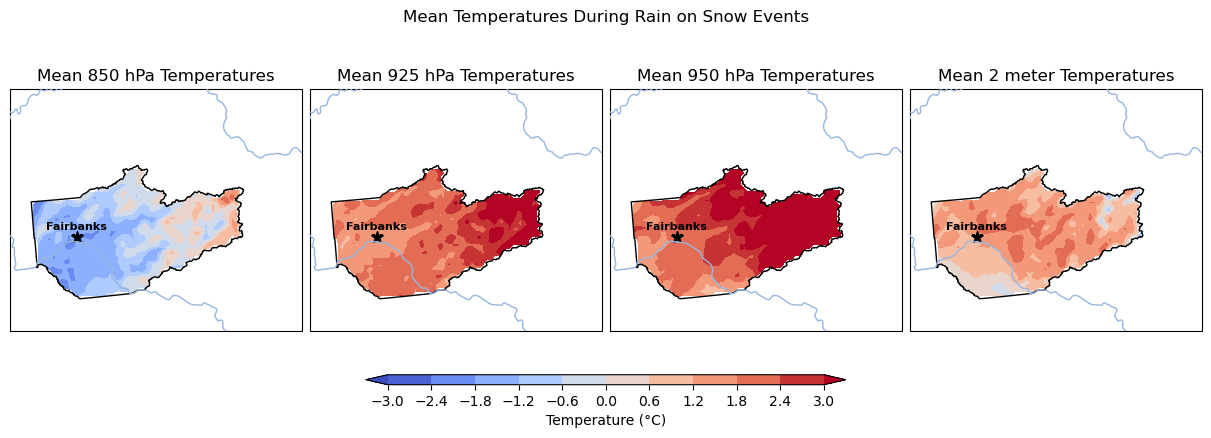

In [77]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65)
    )
}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

fig.suptitle("Mean Temperatures During Rain on Snow Events", y=0.9)

levels = np.linspace(-3, 3, 11)

cf1 = axs[0].contourf(lon, lat, avg_ros_temp_850_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[0].set_title("Mean 850 hPa Temperatures")

cf2 = axs[1].contourf(lon, lat, avg_ros_temp_925_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[1].set_title("Mean 925 hPa Temperatures")

cf3 = axs[2].contourf(lon, lat, avg_ros_temp_950_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[2].set_title("Mean 950 hPa Temperatures")

cf4 = axs[3].contourf(lon, lat, avg_ros_temp_T2_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[3].set_title("Mean 2 meter Temperatures")

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=5, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=9)
    ax.add_feature(cfeature.COASTLINE, zorder=9)
    ax.add_feature(cfeature.RIVERS, zorder=9)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf4, cax=cbar_ax, orientation='horizontal', label='Temperature (°C)', ticks=levels)

fig.patch.set_alpha(0.0)

plt.show()


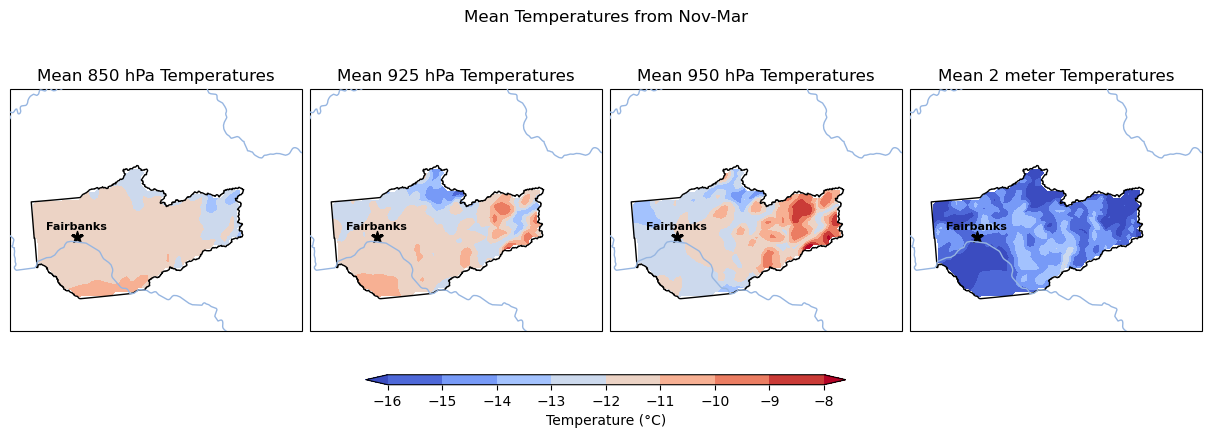

In [78]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65)
    )
}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

fig.suptitle("Mean Temperatures from Nov-Mar", y=0.9)

levels = np.linspace(-16, -8, 9)

cf1 = axs[0].contourf(lon, lat, avg_temp_850_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[0].set_title("Mean 850 hPa Temperatures")

cf2 = axs[1].contourf(lon, lat, avg_temp_925_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[1].set_title("Mean 925 hPa Temperatures")

cf3 = axs[2].contourf(lon, lat, avg_temp_950_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[2].set_title("Mean 950 hPa Temperatures")

cf4 = axs[3].contourf(lon, lat, avg_temp_T2_C, levels=levels, cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
axs[3].set_title("Mean 2 meter Temperatures")

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=5, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=9)
    ax.add_feature(cfeature.COASTLINE, zorder=9)
    ax.add_feature(cfeature.RIVERS, zorder=9)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(cf4, cax=cbar_ax, orientation='horizontal', label='Temperature (°C)', ticks=levels)

fig.patch.set_alpha(0.0)

plt.show()

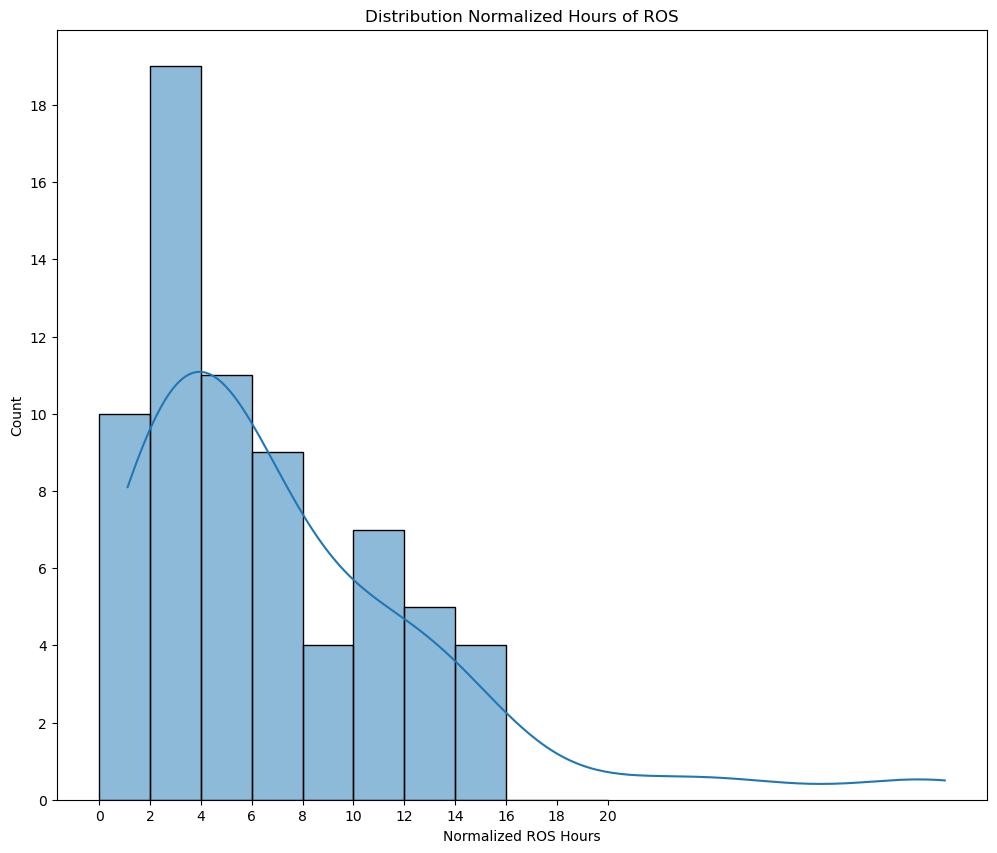

In [98]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(figsize=(12, 10))
days_bins = np.arange(0, 22, 2)
sns.histplot(ros_hours_normalized, kde=True, ax=ax, bins=days_bins)
ax.set_title("Distribution Normalized Hours of ROS")
ax.set(xlabel='Normalized ROS Hours')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticks(np.arange(0, 22,2))
fig.patch.set_alpha(0.0)
plt.show()

In [99]:
avg_ros_temp_850_C_FNSB = []
for i in range(len(data['temp_levels_ros_avg'].season)):
    avg = data['temp_levels_ros_avg'].sel(interp_level=850).isel(season=i).mean().compute().item()
    avg_C = avg - 273.15
    avg_ros_temp_850_C_FNSB.append(avg_C)
print(avg_ros_temp_850_C_FNSB)

avg_ros_temp_925_C_FNSB = []
for i in range(len(data['temp_levels_ros_avg'].season)):
    avg = data['temp_levels_ros_avg'].sel(interp_level=925).isel(season=i).mean().compute().item()
    avg_C = avg - 273.15
    avg_ros_temp_925_C_FNSB.append(avg_C)
print(avg_ros_temp_925_C_FNSB)

avg_ros_temp_950_C_FNSB = []
for i in range(len(data['temp_levels_ros_avg'].season)):
    avg = data['temp_levels_ros_avg'].sel(interp_level=950).isel(season=i).mean().compute().item()
    avg_C = avg - 273.15
    avg_ros_temp_950_C_FNSB.append(avg_C)
print(avg_ros_temp_950_C_FNSB)

[1.1452575683593977, 2.1644836425781477, -0.40515747070310226, -3.3746704101562273, -0.12091674804685226, -2.6453918457031023, -1.6750854492187273, -1.5804199218749773, -4.530706787109352, -0.8362487792968523, 0.04589233398439774, 0.17977294921877274, -0.8351196289062273, 0.29839477539064774, -0.9098571777343523, -3.9077514648437273, -3.6908020019531023, -1.0001586914062273, -3.4911560058593523, -2.1763366699218523, -0.17389526367185226, -1.2243103027343523, -3.4832824707031023, -7.546667480468727, -3.9362243652343523, -2.3635925292968523, 1.0136657714843977, -1.4965576171874773, -3.1126770019531023, -0.38846435546872726, 0.24276123046877274, 2.0918212890625227, -2.4246887207031023, -0.37988891601560226, -1.8355773925781023, -0.14407958984372726, 0.6267333984375227, -1.6908630371093523, -1.4596618652343523, -1.5250915527343523, -2.8114990234374773, -1.3546203613281023, -1.5592102050781023, -1.9712280273437273, -1.9143737792968523, 1.9439636230468977, -3.8349670410156023, 0.093896484375

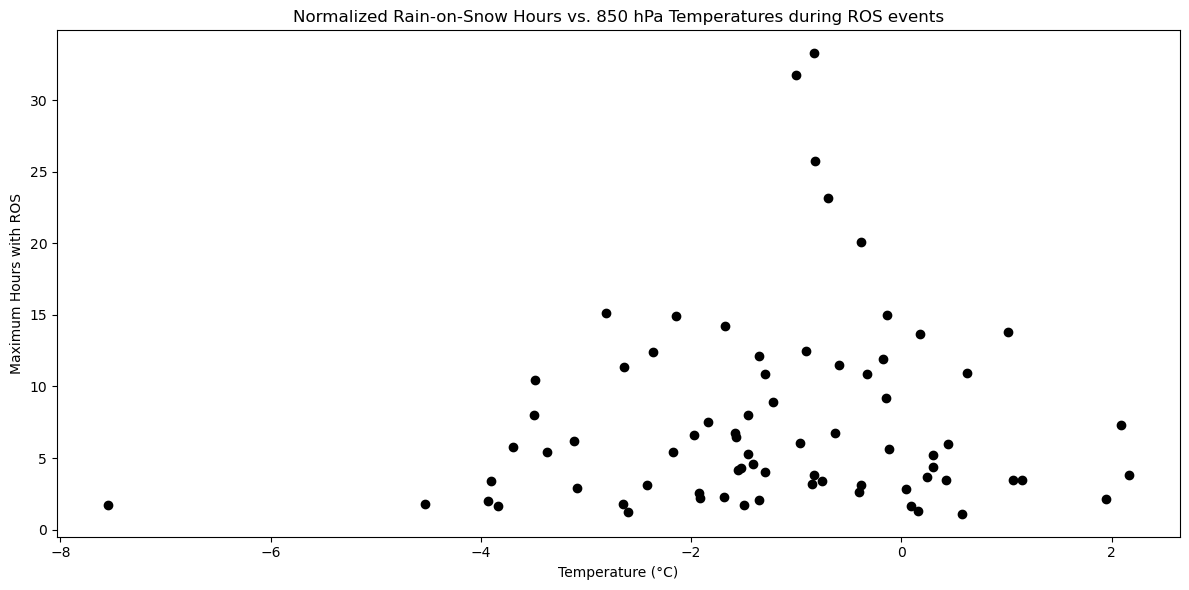

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(avg_ros_temp_850_C_FNSB, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. 850 hPa Temperatures during ROS events')
plt.xlabel('Temperature (°C)')
plt.ylabel('Maximum Hours with ROS')
plt.tight_layout()
plt.show()

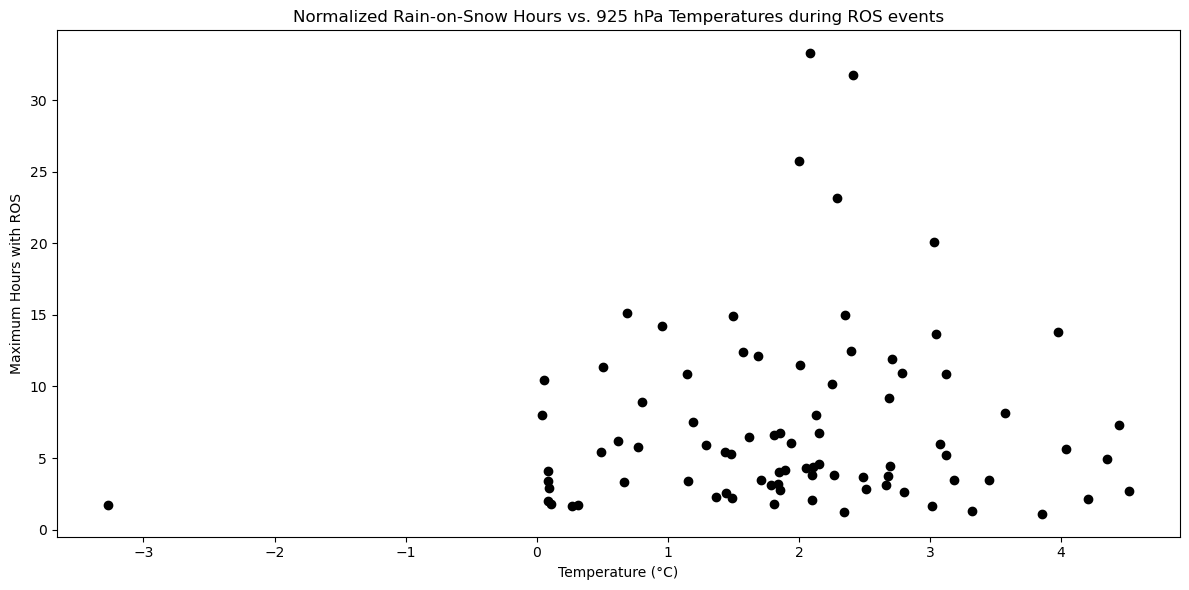

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(avg_ros_temp_925_C_FNSB, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. 925 hPa Temperatures during ROS events')
plt.xlabel('Temperature (°C)')
plt.ylabel('Maximum Hours with ROS')
plt.tight_layout()
plt.show()

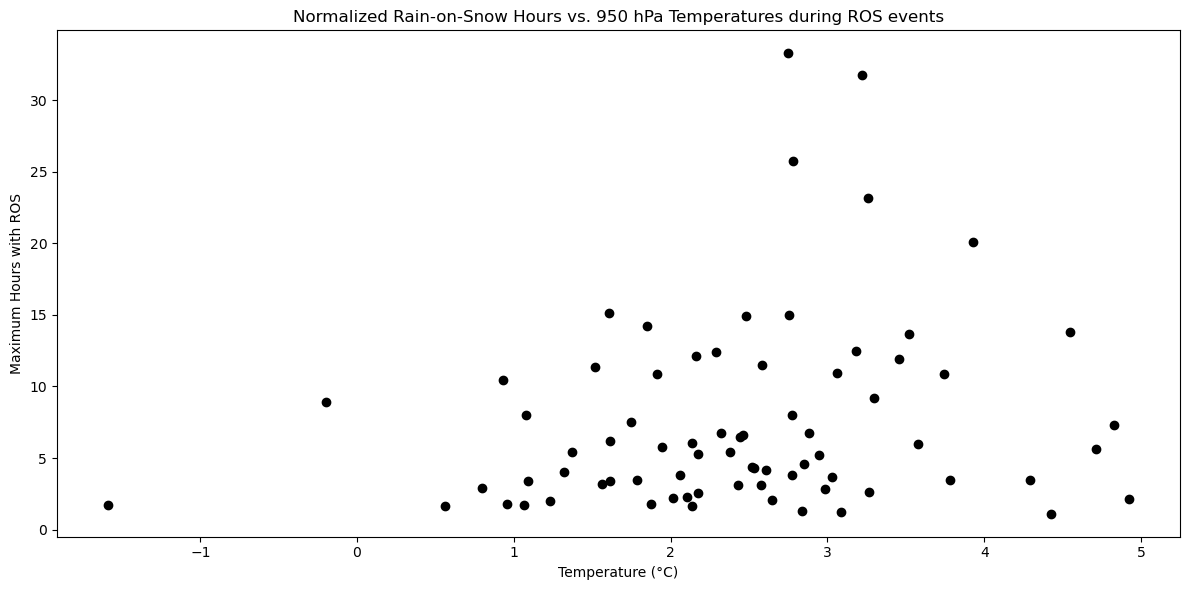

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(avg_ros_temp_950_C_FNSB, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. 950 hPa Temperatures during ROS events')
plt.xlabel('Temperature (°C)')
plt.ylabel('Maximum Hours with ROS')
plt.tight_layout()
plt.show()

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(T2_avg_ROS_fnsb_C, ros_hours_normalized, marker='o', linestyle='', color='black',label='2 meter')
plt.title('Normalized Rain-on-Snow Hours vs. 2 meter Temperatures during ROS events')
plt.xlabel('Temperature (°C)')
plt.ylabel('Normalized Hours with ROS')
plt.tight_layout()
plt.show()

NameError: name 'ros_hours_normalized' is not defined

<Figure size 1200x600 with 0 Axes>

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(avg_ros_temp_850_C_FNSB, ros_hours_normalized, marker='o', linestyle='',markeredgecolor='black', color='aqua',label='850hPa')
plt.plot(avg_ros_temp_925_C_FNSB, ros_hours_normalized, marker='o', linestyle='', markeredgecolor='black',color='lightblue',label='925hPa')
plt.plot(avg_ros_temp_950_C_FNSB, ros_hours_normalized, marker='o', linestyle='', markeredgecolor='black',color='blue',label='950hPa')
plt.plot(T2_avg_ROS_fnsb_C, ros_hours_normalized, marker='o', linestyle='', markeredgecolor='black', color='darkblue',label='2meter')
plt.title('Normalized ROS Hours vs. Temperature at Various Atmospheric Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('Maximum Hours with ROS')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'avg_ros_temp_850_C_FNSB' is not defined

<Figure size 1200x600 with 0 Axes>

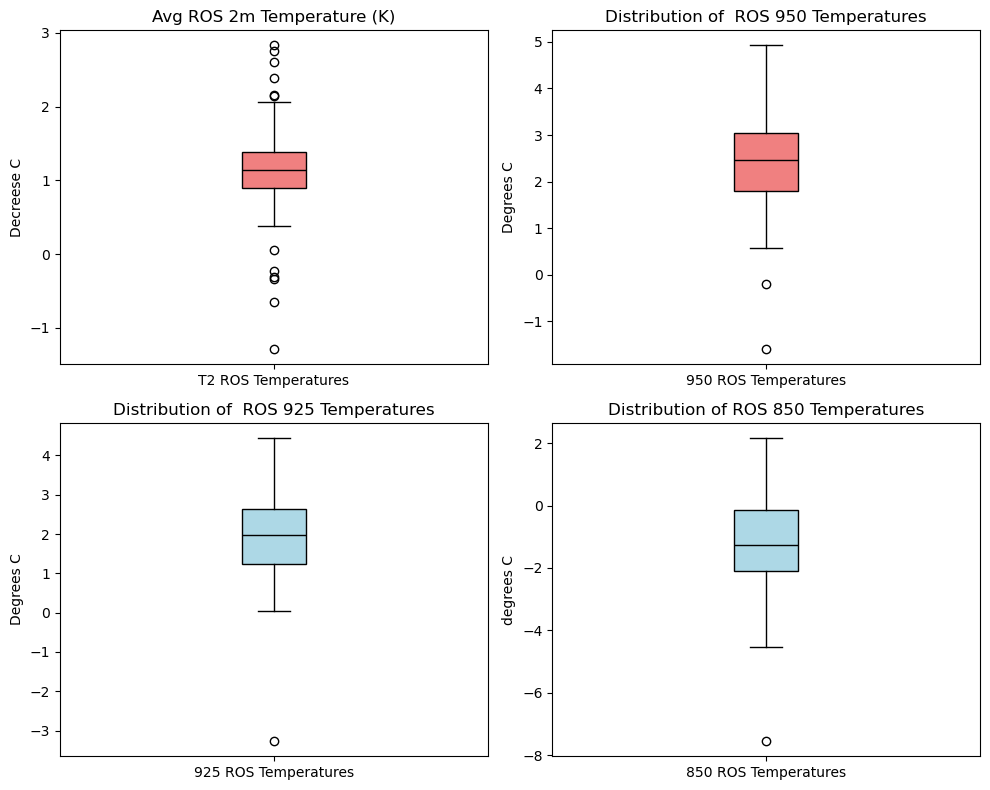

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].boxplot(T2_avg_ROS_fnsb_C, patch_artist=True,boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='black'))
axs[0, 0].set_title('Avg ROS 2m Temperature (K)')
axs[0, 0].set_ylabel('Decreese C')
axs[0, 0].set_xticks([1])
axs[0, 0].set_xticklabels(['T2 ROS Temperatures'])

axs[0, 1].boxplot(avg_ros_temp_950_C_FNSB, patch_artist=True, boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='black'))
axs[0, 1].set_title('Distribution of  ROS 950 Temperatures')
axs[0, 1].set_ylabel('Degrees C')
axs[0, 1].set_xticks([1])
axs[0, 1].set_xticklabels(['950 ROS Temperatures'])

axs[1, 0].boxplot(avg_ros_temp_925_C_FNSB, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='black'))
axs[1, 0].set_title('Distribution of  ROS 925 Temperatures')
axs[1, 0].set_ylabel('Degrees C')
axs[1, 0].set_xticks([1])
axs[1, 0].set_xticklabels(['925 ROS Temperatures'])

axs[1, 1].boxplot(avg_ros_temp_850_C_FNSB, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='black'))
axs[1, 1].set_title('Distribution of ROS 850 Temperatures')
axs[1, 1].set_ylabel('degrees C')
axs[1, 1].set_xticks([1])
axs[1, 1].set_xticklabels(['850 ROS Temperatures'])

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

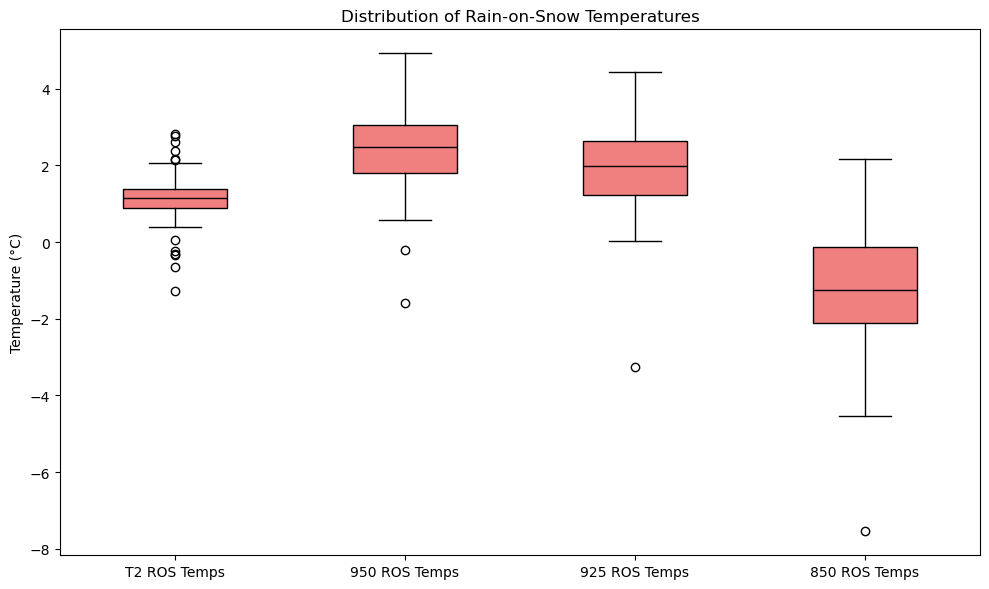

In [115]:
import matplotlib.pyplot as plt

# Data to plot
data = [
    T2_avg_ROS_fnsb_C,
    avg_ros_temp_950_C_FNSB,
    avg_ros_temp_925_C_FNSB,
    avg_ros_temp_850_C_FNSB
]

labels = [
    'T2 ROS Temps',
    '950 ROS Temps',
    '925 ROS Temps',
    '850 ROS Temps'
]

colors = ['lightcoral', 'lightcoral', 'lightcoral', 'lightcoral']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
box = ax.boxplot(data, patch_artist=True, medianprops=dict(color='black'))

# Set colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Labeling
ax.set_title('Distribution of Rain-on-Snow Temperatures')
ax.set_ylabel('Temperature (°C)')
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)
fig.patch.set_alpha(0.0)

plt.grid(axis='y', linestyle='', alpha=0.5)
plt.tight_layout()
plt.show()


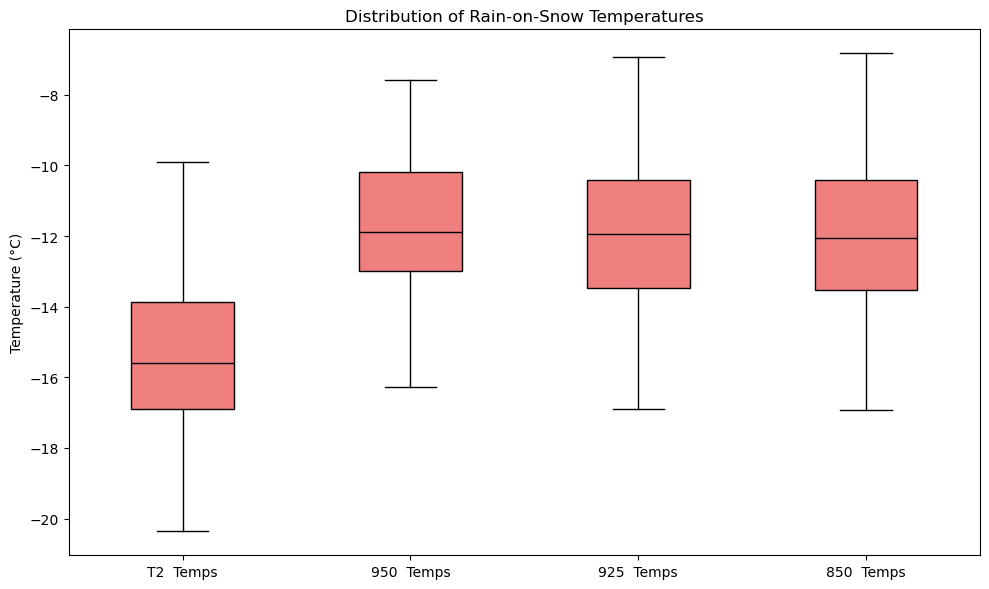

In [16]:
avg_temp_850_s=np.mean(data['temp_levels_avg'].sel(interp_level=850),axis=(1,2))
avg_temp_925_s=np.mean(data['temp_levels_avg'].sel(interp_level=925),axis=(1,2))
avg_temp_950_s=np.mean(data['temp_levels_avg'].sel(interp_level=950),axis=(1,2))
avg_temp_850_C_s=avg_temp_850_s-273.15
avg_temp_925_C_s=avg_temp_925_s-273.15
avg_temp_950_C_s=avg_temp_950_s-273.15
data = [
    T2_avg_fnsb_C,
    avg_temp_850_C_s,
    avg_temp_925_C_s,
    avg_temp_950_C_s
]

labels = [
    'T2  Temps',
    '950  Temps',
    '925  Temps',
    '850  Temps'
]

colors = ['lightcoral', 'lightcoral', 'lightcoral', 'lightcoral']

fig, ax = plt.subplots(figsize=(10, 6))

box = ax.boxplot(data, patch_artist=True, medianprops=dict(color='black'))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('Distribution of Rain-on-Snow Temperatures')
ax.set_ylabel('Temperature (°C)')
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)
fig.patch.set_alpha(0.0)

plt.grid(axis='y', linestyle='', alpha=0.5)
plt.tight_layout()
plt.show()
